In [1]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData

from matplotlib.colors import LogNorm

from IPython.display import display, Markdown, clear_output

import inspect
import importlib
import warnings
warnings.filterwarnings('ignore')

# Plot setup
matplotlib.rc('font', size=22, family='normal', weight='bold')
plt.rcParams['figure.figsize'] = [10, 4]
np.printoptions(suppress=True)

# Lots of functions piped from Bernstein's C code:

In [2]:
'''Here are some functions piped from Bernstein's transform.c, part of orbfit'''

ECL = np.radians(23.43928)

def check_latlon0(lat0, lon0):
    '''
    This function is adapted from Bernstein's transform.c, part of orbfit.
    It doesn't actually check anything here, just calculates all the sines and cosines.
    '''
    clat0 = np.cos(lat0)
    slat0 = np.sin(lat0)
    clon0 = np.cos(lon0)
    slon0 = np.sin(lon0)
    
    return clat0, slat0, clon0, slon0

def ec_to_proj(lat_ec, lon_ec, lat0, lon0):
    '''
    First routine goes from ecliptic lat/lon to projected x/y angles
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)
    cdlon = np.cos(lon_ec - lon0)
    sdlon = np.sin(lon_ec - lon0)
    clat  = np.cos(lat_ec)
    slat  = np.sin(lat_ec)

    xp = clat * sdlon
    yp = clat0*slat - slat0*clat*cdlon
    zp = slat0*slat + clat0*clat*cdlon

    x_proj = xp/zp
    y_proj = yp/zp

    return x_proj, y_proj


def proj_to_ec(x_proj, y_proj, lat0, lon0):
    '''
    Now the inverse, from projected xy to ecliptic lat/lon
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    zp = 1./np.sqrt(1 + x_proj*x_proj + y_proj*y_proj)
    lat_ec = np.arcsin( zp* (slat0 + y_proj*clat0) )
    lon_ec = lon0 + np.arcsin( x_proj * zp / np.cos(lat_ec) )

    return lat_ec, lon_ec

def xyz_ec_to_proj(x_ec, y_ec, z_ec, lat0, lon0):
    '''
    Next go from x,y,z in ecliptic orientation to x,y,z in tangent-point orientiation.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    x_p = -slon0 * x_ec + clon0 * y_ec
    y_p = -clon0*slat0*x_ec - slon0*slat0*y_ec + clat0*z_ec
    z_p =  clon0*clat0*x_ec + slon0*clat0*y_ec + slat0*z_ec

    return x_p, y_p, z_p

def xyz_proj_to_ec(x_p, y_p, z_p, lat0, lon0):
    '''
    And finally from tangent x,y,z to ecliptic x,y,z.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    x_ec =-slon0 *x_p - clon0*slat0*y_p + clon0*clat0*z_p
    y_ec = clon0 *x_p - slon0*slat0*y_p + slon0*clat0*z_p
    z_ec = clat0 * y_p + slat0 * z_p

    return x_ec, y_ec, z_ec

def eq_to_ec(ra_eq, dec_eq):
    '''
    First takes RA,DEC in equatorial to ecliptic.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    se = np.sin(ECL)
    ce = np.cos(ECL)
    sd = ce * np.sin(dec_eq) - se * np.cos(dec_eq)*np.sin(ra_eq)
    lat_ec = np.arcsin(sd)

    y = ce*np.cos(dec_eq)*np.sin(ra_eq) + se*np.sin(dec_eq)
    x = np.cos(dec_eq)*np.cos(ra_eq)
    lon_ec = np.arctan2(y,x)

    return lat_ec, lon_ec

def xyz_eq_to_ec(x_eq, y_eq, z_eq):
    '''
    And transform x,y,z from eq to ecliptic
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    se = np.sin(ECL)
    ce = np.cos(ECL)

    x_ec = x_eq
    y_ec = ce*y_eq + se*z_eq
    z_ec = -se*y_eq + ce*z_eq

    return x_ec, y_ec, z_ec

def ec_to_eq(lat_ec, lon_ec):
    '''
    And transform x,y,z from eq to ecliptic.
    
    To reverse above, just flip sign of ECL effectively.
    '''
    se = np.sin(-ECL)
    ce = np.cos(ECL)

    sd = ce * np.sin(lat_ec) - se * np.cos(lat_ec)*np.sin(lon_ec)
    dec_eq = np.arcsin(sd)

    y = ce*np.cos(lat_ec)*np.sin(lon_ec) + se*np.sin(lat_ec)
    x = np.cos(lat_ec)*np.cos(lon_ec)
    ra_eq = np.arctan2(y,x)

    return ra_eq, dec_eq

def xyz_ec_to_eq(x_ec, y_ec, z_ec):
    '''
    And transform x,y,z from ecliptic to eq.
    
    To reverse above, just flip sign of ECL effectively.
    '''
    se = np.sin(-ECL);
    ce = np.cos(ECL);

    x_eq = x_ec
    y_eq = ce*y_ec + se*z_ec
    z_eq = -se*y_ec + ce*z_ec

    return x_eq, y_eq, z_eq

# New functions I actually wrote:

In [3]:
def get_heliocentric_ecliptic_XYZ_from_JPL(times, obs_code='500',
                                           verbose=False):
    '''
    Query horizons for the ECLIPTIC heliocentric
    observatory position at a sequence of times.

    input:
    obs_code    - string
                - Note that Horizons uses some weird ones sometimes,
                  like "500@-95" for Tess.
    times       - array of JD times (UTC)
    '''
    from astroquery.jplhorizons import Horizons
    times_AP = Time(times, format='jd', scale='utc')
    # convert times to tdb, the time system used by Horizons for vectors. 
    times_tdb = times_AP.tdb.value
    horizons_query = Horizons(id='10', location=obs_code,
                              epochs=times_tdb, id_type='id')
    horizons_vector = horizons_query.vectors(refplane='ecliptic')
    helio_OBS_ecl = 0 - np.array([horizons_vector['x'], horizons_vector['y'],
                                  horizons_vector['z']]).T
    if verbose:
        print('No verbosity implemented yet, sorry')
    return helio_OBS_ecl

def abg2theta(timesJD, timeJD0, abg, obscode, xyz_E, GM=c.GM_sun.to('au**3/year**2').value):
    '''
    Converts input abg to a theta vector at time dtime from reference time.
    inputs:
    -------
    abg    - array length 6 - array containing alpha, beta, gamma,
                              alpha-dot, beta-dot, gamma-dot.
    timesJD - float - times in Julian days
    '''
    # convert times to YEARS since reference time, accounting for light travel time
    light_travel_time = (1/abg[2] * (u.au/c.c).to(u.yr)).value
    dtime = (timesJD - timeJD0) * u.day.to(u.yr) - light_travel_time
    # Calculate gravitational effect
    acc_z = - GM * abg[2] ** 2
    grav_x, grav_y, grav_z = 0, 0, 0.5 * acc_z * dtime ** 2
    # XYZ of observer:
    x_E, y_E, z_E = xyz_E.T
    
    num_x = abg[0] + abg[3] * dtime + abg[2] * grav_x - abg[2] * x_E
    num_y = abg[1] + abg[4] * dtime + abg[2] * grav_y - abg[2] * y_E
    denominator = 1 + abg[5] * dtime + abg[2] * grav_z - abg[2] * z_E
    theta_x = num_x / denominator                       # eq 6
    theta_y = num_y / denominator                       # eq 6
    #theta_x = abg[0] + abg[3] * dtime - abg[2] * x_E   # eq 16
    #theta_y = abg[1] + abg[4] * dtime - abg[2] * y_E   # eq 16
    return np.array([theta_x, theta_y]).T

# Matt's function with gravity, for reference:

In [4]:
def fit_tracklet(t_ref, g, gdot, v, GM=c.GM_sun.to('au**3/year**2').value):
    '''
    A function Matt H sent to me. 
    Not used here, just used for reference for the Gravitational term in abg2theta.
    '''
    # Here's a version that incorporates radial gravitational
    # acceleration
   
    t_emit = [(obs[0]-obs[1]-t_ref) for obs in v]
    acc_z = -GM*g*g
    fac =[(1.0 + gdot*t + 0.5*g*acc_z*t*t - g*obs[7]) for obs, t in zip(v, t_emit)]
               
    A = np.vstack([t_emit, np.ones(len(t_emit))]).T
   
    x = [obs[2]*f + obs[5]*g for obs, f in zip(v, fac)]                
    mx, cx = np.linalg.lstsq(A, x)[0]
           
    y = [obs[3]*f + obs[6]*g for obs, f in zip(v, fac)]                
    my, cy = np.linalg.lstsq(A, y)[0]
   
    return (cx, mx, cy, my, t_emit[0])

# Initial conditions and expected values:

In [5]:
'''
Setting some initial conditions for transforming 2015 RS281.
These were obtained using Bernstein's fit_radec and an obs80 file that includes 
a measurement of the first observation as the first line (making it reference time & direction).
    K15RS1S  C2016 08 27.36490 00 41 35.095+06 39 14.91                     568
Full obs file in shifty/dev_data/K15RS1S.obs
'''
abg = np.array([0.00000984, -0.00001155, 0.02301338,           # alpha, beta, gamma
                0.01409909, -0.01679783, 0.00000000])           # a-dot, b-dot, g-d
time0 = 2457626.868610                                          # Reference time
latlon0 = np.radians([2.0088828, 12.1771580])                 # Reference latitude & longitude, radians
print(latlon0)

[0.03506162 0.2125315 ]


In [24]:
'''
These are the times in the shifty/dev_data/K15RS1S.obs file, and below are the thetas printed by
fit_radec < shifty/dev_data/K15RS1S.obs '''
times_str = ['2016 08 26.36861', '2016 08 26.38440', '2016 08 26.40924', '2016 08 26.43305', '2016 08 26.45707',
             '2016 08 26.48136', '2016 08 26.53093', '2016 08 26.55626', '2016 08 26.58106', '2016 08 26.60528',
             '2016 08 26.63031', '2016 08 27.36493', '2016 08 27.38069', '2016 08 27.40521', '2016 08 27.42903',
             '2016 08 27.45310', '2016 08 27.47736', '2016 08 27.57675', '2016 08 27.60094', '2016 08 27.62583']
ymd = np.genfromtxt(times_str)
years = ymd[:, 0].astype(int)
months = ymd[:, 1].astype(int)
dd = ymd[:, 2]
days = dd.astype(int)
hh = (dd - days) * 24
hours = hh.astype(int)
mm = (hh - hours) * 60
minutes = mm.astype(int)
seconds = (mm - minutes) * 60
years, months, days, hours, minutes, seconds
times = Time({'year':years, 'month':months, 'day':days, 'hour':hours, 'minute':minutes, 'second':seconds}).mjd+2400000.5
times_tst = times.copy()
# Thetas from fit_radec:
expected_fitradec = np.array([[0.000, 0.000], [-0.704, -0.135], [-2.252, -0.346], [-3.620, -0.523], [-4.953, -0.609],
                              [-6.499, -0.821], [-9.066, -1.141], [-10.612, -1.352], [-11.984, -1.530], [-13.394, -1.799],
                              [-14.862, -1.828], [-55.906, -7.730], [-56.751, -7.805], [-58.158, -8.075], [-59.533, -8.252],
                              [-60.862, -8.339], [-62.273, -8.608], [-68.029, -9.202], [-69.400, -9.379], [-70.853, -9.739]])


In [7]:
'''
Get the EXPECTED shifts from the JPL Horizons ephemerides.
'''
from astroquery.jplhorizons import Horizons
# Query for reference time:
horizons_query0 = Horizons(id='2015 RS281', location='568', epochs=time0, id_type='smallbody')
horizons_ephem0 = horizons_query0.ephemerides(extra_precision=False)
# Query for whole array of times:
horizons_query = Horizons(id='2015 RS281', location='568', epochs=times, id_type='smallbody')
horizons_ephem = horizons_query.ephemerides(extra_precision=False)

latlon_expected = np.array(eq_to_ec(np.radians(horizons_ephem['RA']), np.radians(horizons_ephem['DEC']))).T
thetas_horizons = np.array(ec_to_proj(*latlon_expected.T, *latlon0)).T
thetas_horizons_asec = np.degrees(thetas_horizons) * 3600

# Now calculate thetas from abg:

In [8]:
'''
Get the ecliptic position of the observer position. 
'''
# Observer's heliocentric ecliptic location at all times.
observer_helio_ecliptic = get_heliocentric_ecliptic_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_ecliptic0 = get_heliocentric_ecliptic_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_ecliptic_relative = observer_helio_ecliptic - observer_helio_ecliptic0

In [9]:
'''
Convert observer location to projection coordinate system, then convert abg to thetas.
'''
observer_projected = np.array([xyz_ec_to_proj(*obspos, *latlon0) for obspos in observer_helio_ecliptic_relative])
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected, GM=c.GM_sun.to('au**3/year**2').value)
# Convert to arcseconds
thetas_asec = np.degrees(thetas) * 3600  # radians to arc-sec

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


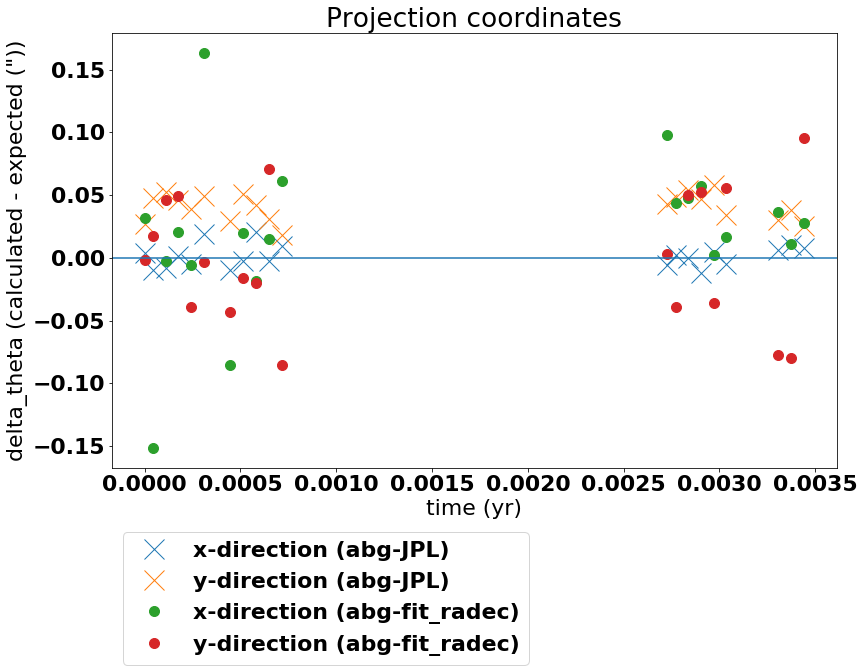

In [10]:
plt.rcParams['figure.figsize'] = [13, 8]
dtimes_yr = (times-time0) * u.day.to(u.yr)
plt.plot(dtimes_yr, (thetas_asec - thetas_horizons_asec)[:, 0], 'x', label='x-direction (abg-JPL)', ms=20)
plt.plot(dtimes_yr, (thetas_asec - thetas_horizons_asec)[:, 1], 'x', label='y-direction (abg-JPL)', ms=20)
plt.plot(dtimes_yr, (thetas_asec - expected_fitradec)[:, 0], '.', label='x-direction (abg-fit_radec)', ms=20)
plt.plot(dtimes_yr, (thetas_asec - expected_fitradec)[:, 1], '.', label='y-direction (abg-fit_radec)', ms=20)
plt.axhline(0)
plt.ylabel('expected - calculated (")')
plt.ylabel('delta_theta (calculated - expected ("))')
plt.xlabel('time (yr)')
plt.title('Projection coordinates')
plt.legend(loc='center left', bbox_to_anchor=(0, -0.3))

In [11]:
# Convert thetas to RA & Dec. 
'''
Get the EXPECTED shifts from the JPL Horizons ephemerides.
'''
from astroquery.jplhorizons import Horizons
horizons_query = Horizons(id='2015 RS281', location='568', epochs=times, id_type='smallbody')
horizons_radec = horizons_query.ephemerides(extra_precision=False)
horizons_query0 = Horizons(id='2015 RS281', location='568', epochs=time0, id_type='smallbody')
horizons_radec0 = horizons_query0.ephemerides(extra_precision=False)
# extra_precision=True would be better, but JPL recently broke astroquery.
shift_expected_RA = (horizons_radec['RA'] - horizons_radec0['RA']) * 3600 * np.cos(np.radians(horizons_radec['DEC']))
shift_expected_Dec = (horizons_radec['DEC'] - horizons_radec0['DEC']) * 3600
shift_expected_RADEC_asec = np.array([shift_expected_RA, shift_expected_Dec]).T

Text(0, 0.5, 'Dec residual (From ABG - Horizons)')

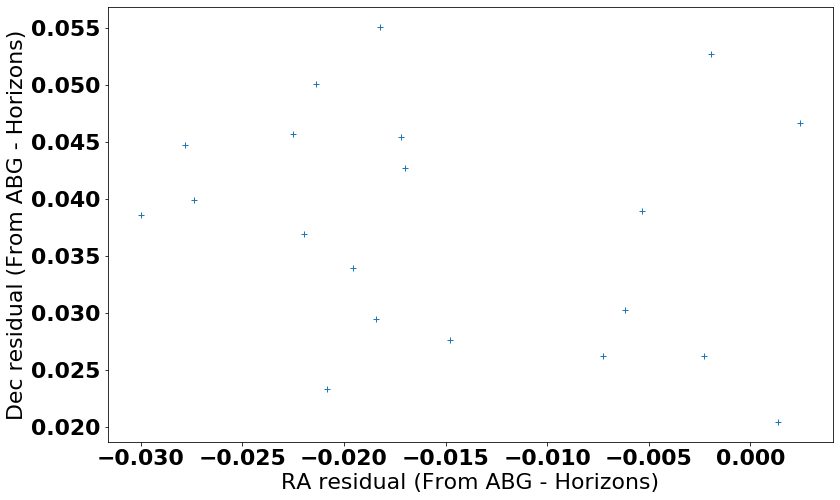

In [12]:
ec_from_abg = proj_to_ec(thetas[:, 0], thetas[:, 1], *latlon0)
radec_from_abg = np.degrees(ec_to_eq(*ec_from_abg))
plt.plot((radec_from_abg[0]-horizons_radec['RA'])*3600, (radec_from_abg[1]-horizons_radec['DEC'])*3600, '+')
plt.xlabel('RA residual (From ABG - Horizons)')
plt.ylabel('Dec residual (From ABG - Horizons)')

# Shift+stack stuff!

In [18]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
importlib.reload(imagehandler)
# This just defines 24 filenames: 
# 2015RS281_HSC20160825_100.fits to 2015RS281_HSC20160825_111.fits and 
# 2015RS281_HSC20160826_112.fits to 2015RS281_HSC20160826_123.fits,
# without just having them all pasted in here: 
filenames=['../dev_data/2015RS281_HSC20160826_112.fits'.replace('112', str(i)) for i in np.arange(100, 124)]
filenames[:12]=[filenamei.replace('0826', '0825') for filenamei in filenames[:12]]

### Reference: Shift+stack using shifts from Horizons

Combining images using median stacking.


Peak count $\pm$ noise = 59.7 $\pm$  4.0 (14.8$\sigma$)

Saving to file stack.fits
Done!


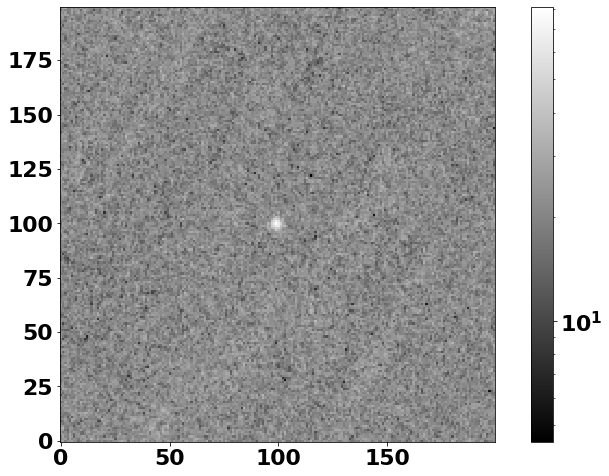

In [19]:
'''
Get times and shifts (as calculated by Horizons)
'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, verbose=False, **{'EXPUNIT':'m'})
shiftss = D._calculate_shifts_from_known(object_name='2015 RS281', obs_code='568')
shifts = shiftss - shiftss[12]  # Because image 13 (first image on second night) is the reference time. 
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5

'''
Shift+stack using the known (from Horizons + WCS) shifts.
'''
D.integer_shift(shifts, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[520:720,405:605]-np.nanmedian(D.stacked_data.data[520:720,405:605]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))
D.save_stack('stack.fits')

Text(0, 0.5, 'Dec relative to reference time')

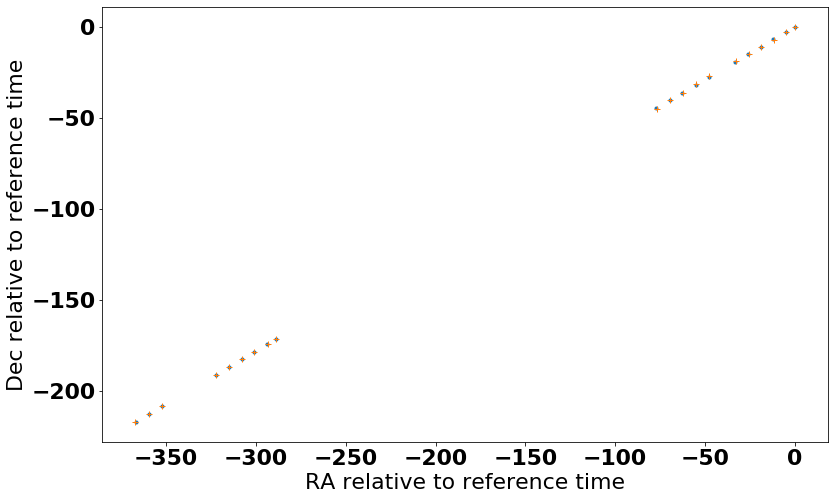

In [20]:
pix_from_abg=np.array(D.image_data.WCS[0].all_world2pix(radec_from_abg[0, :], radec_from_abg[1, :], 0))[::-1]
shifts_from_abg = pix_from_abg[:, 0] - pix_from_abg.T
shiftsi=(shifts-shifts[0])[[0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,21,22,23]]
plt.plot(*shifts_from_abg.T, '.')
plt.plot(*shiftsi.T, '+')
plt.xlabel('RA relative to reference time')
plt.ylabel('Dec relative to reference time')

Text(0, 0.5, 'Residual (")')

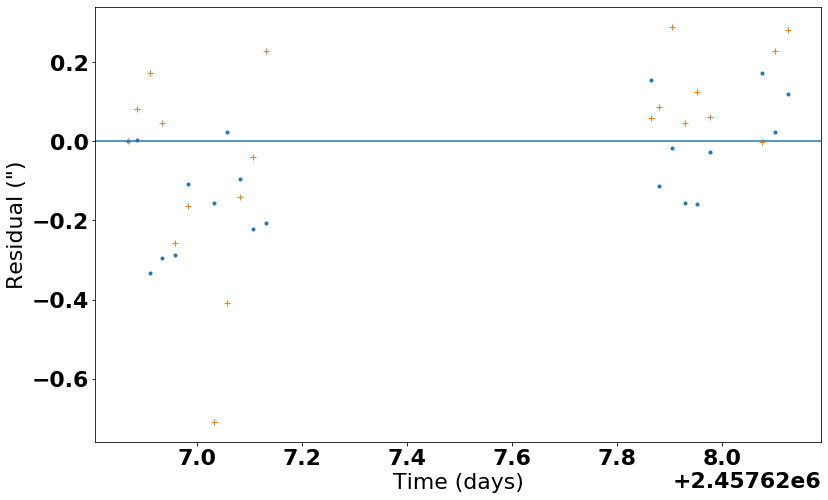

In [25]:
plt.plot(times_tst, (shifts_from_abg-shiftsi)[:,0], '.', label='RA residual (abg prediction - measured astrometry)')
plt.plot(times_tst, (shifts_from_abg-shiftsi)[:,1], '+', label='Dec residual (abg prediction - measured astrometry)')
plt.axhline(0)
plt.xlabel('Time (days)')
plt.ylabel('Residual (")')

### Just convert thetas to radec and use WCS to figure out pixel shift. 
Since it seems I can't figure out how to convert thetas directly to pixel shifts. 

In [26]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)

In [30]:
'''Shift+stack using the shift calculated from abg, using improved pixel scale & rotation.'''
'''
Get the position of the observer position. 
'''
# Observer's heliocentric ecliptic location at all times.
observer_helio_ecliptic = get_heliocentric_ecliptic_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_ecliptic0 = get_heliocentric_ecliptic_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_ecliptic_relative = observer_helio_ecliptic - observer_helio_ecliptic0

'''
Convert observer location to projection coordinate system, then convert abg to thetas.
'''
observer_projected = np.array([xyz_ec_to_proj(*obspos, *latlon0) for obspos in observer_helio_ecliptic_relative])
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected)
# Convert to arcseconds
thetas_asec = np.degrees(thetas) * 3600  # radians to arc-sec
# Convert to pixels
#thetas_pixels = thetas_asec / 0.170      # This could be more accurate, but is pretty close. 
#thetas_pixels = thetas_asec / pix_scale  #   based on calculation above

'''Convert to pixel shift'''
ec_from_abg = proj_to_ec(thetas[:, 0], thetas[:, 1], *latlon0)
radec_from_abg = np.degrees(ec_to_eq(*ec_from_abg))
pix_from_abg=np.array(D.image_data.WCS[0].all_world2pix(radec_from_abg[0, :], radec_from_abg[1, :], 0))[::-1]
shifts_from_abg = pix_from_abg[:, 12] - pix_from_abg.T

'''Make nice plot'''

plt.plot(times, (shifts-shifts_from_abg)[:, 0], '.', label='x-direction')
plt.plot(times, (shifts-shifts_from_abg)[:, 1], '.', label='y-direction')
plt.xlabel('Time [MJD]')
plt.ylabel('Pixel shift (expected - calculated)')
plt.title('Pixel coordinates')
plt.legend()

plt.figure()

'''
Shift and stack using the calculated shifts.
'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.integer_shift(shifts_from_abg, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[520:720,405:605]-np.nanmedian(D.stacked_data.data[520:720,405:605]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

ValueError: operands could not be broadcast together with shapes (24,2) (20,2) 

### "Accurately" calculate CCD orientation & pixel scale
Since it seems the best-guess pixel scale and orientation seems just slightly off, let's calculate the actual orientation & scale. 

In [ ]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)

In [ ]:
# Get centre pixel from WCS
CRPIX1 = D.image_data.header[0]['CRPIX1']
CRPIX2 = D.image_data.header[0]['CRPIX2']
# RA & Dec of centre pixel & then offset 100 pixels in each direction:
ra_CRPIX, dec_CRPIX = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1, CRPIX2, 1))
ra1, dec1 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1+100, CRPIX2, 1))
ra2, dec2 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1-100, CRPIX2, 1))
ra3, dec3 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1, CRPIX2+100, 1))
ra4, dec4 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1, CRPIX2-100, 1))

# delta_ra & delta_dec of the four offsets:
d1=np.array([(ra1-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec1)/2)), dec1-dec_CRPIX])
d2=np.array([(ra2-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec2)/2)), dec2-dec_CRPIX])
d3=np.array([(ra3-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec3)/2)), dec3-dec_CRPIX])
d4=np.array([(ra4-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec4)/2)), dec4-dec_CRPIX])

#Pixel scale:
pix_scale4 = (np.sum([d1 ** 2, d2 ** 2, d3 ** 2, d4 ** 2], 1)) ** 0.5 * 3600 / 100
pix_scale = np.array([np.mean(pix_scale4[0:2]), np.mean(pix_scale4[2:])])
print(f'Pixel scale (x-dir, y-dir) = {pix_scale}')

#angle between pixel grid and RA-Dec coordinates
angle = np.array([np.arctan2(d1[0], d1[1]) , np.arctan2(-d2[0], -d2[1]), 
                  np.arctan2(-d3[1], d3[0]), np.arctan2(d4[1], -d4[0])]) % (2*np.pi)
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[0]):8.4f}')
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[1]):8.4f}')
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[2]):8.4f}')
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[3]):8.4f}')

In [ ]:
# Get centre pixel from WCS
CRPIX1 = D.image_data.header[0]['CRPIX1']
CRPIX2 = D.image_data.header[0]['CRPIX2']
CRPIX1 = D.image_data.header[0]['NAXIS1']/2
CRPIX2 = D.image_data.header[0]['NAXIS2']/2
CRPIX1 = 505
CRPIX2 = 620
# RA & Dec of centre pixel & then offset 100 pixels in each direction:
ra_CRPIX, dec_CRPIX = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1, CRPIX2, 1))
ra1, dec1 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1+100, CRPIX2, 1))
ra2, dec2 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1-100, CRPIX2, 1))
ra3, dec3 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1, CRPIX2+100, 1))
ra4, dec4 = np.array(D.image_data.WCS[0].all_pix2world(CRPIX1, CRPIX2-100, 1))

# delta_ra & delta_dec of the four offsets:
d1=np.array([(ra1-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec1)/2)), dec1-dec_CRPIX])
d2=np.array([(ra2-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec2)/2)), dec2-dec_CRPIX])
d3=np.array([(ra3-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec3)/2)), dec3-dec_CRPIX])
d4=np.array([(ra4-ra_CRPIX)/np.cos(np.radians((dec_CRPIX+dec4)/2)), dec4-dec_CRPIX])

#Pixel scale:
pix_scale4 = (np.sum([d1 ** 2, d2 ** 2, d3 ** 2, d4 ** 2], 1)) ** 0.5 * 3600 / 100
pix_scale = np.array([np.mean(pix_scale4[0:2]), np.mean(pix_scale4[2:])])
print(f'Pixel scale (x-dir, y-dir) = {pix_scale}')

#angle between pixel grid and RA-Dec coordinates
angle = np.array([np.arctan2(d1[0], d1[1]) , np.arctan2(-d2[0], -d2[1]), 
                  np.arctan2(-d3[1], d3[0]), np.arctan2(d4[1], -d4[0])]) % (2*np.pi)
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[0]):8.4f}')
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[1]):8.4f}')
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[2]):8.4f}')
print(f'Angle acw between positive RA and positive x-axis of pixel grid: {np.degrees(angle[3]):8.4f}')

In [28]:
'''Shift+stack using the shift calculated from abg, using improved pixel scale & rotation.'''
D.integer_shift(shifts, padmean=True)

'''
Get the position of the observer position. 
'''
# Observer's heliocentric ecliptic location at all times.
observer_helio_ecliptic = get_heliocentric_ecliptic_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_ecliptic0 = get_heliocentric_ecliptic_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_ecliptic_relative = observer_helio_ecliptic - observer_helio_ecliptic0

'''
Convert observer location to projection coordinate system, then convert abg to thetas.
'''
observer_projected = np.array([xyz_ec_to_proj(*obspos, *latlon0) for obspos in observer_helio_ecliptic_relative])
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected)
# Convert to arcseconds
thetas_asec = np.degrees(thetas) * 3600  # radians to arc-sec
# Convert to pixels
#thetas_pixels = thetas_asec / 0.170      # This could be more accurate, but is pretty close. 
thetas_pixels = thetas_asec / pix_scale  #   based on calculation above

'''Rotate thetas to CCD orientation'''
proj2ccd_angle = ECL                          # Could be whatever, depending on camera orientation
#proj2ccd_angle = ECL + np.mean(np.pi+angle)   # Could be whatever, depending on camera orientation
'''
I'm actually confused here. Why do I need to add 180-angle rather than just subtracting the angle?
The positive X axis is ~180 degrees from the positive Dec axis, and Y+ is ~180 deg from RA+ axis, 
so shouldn't this be ECL-180? I feel like I have a sign wrong somewhere that is causing this... 
Like in the direction of how shifts are defined, or something. 
'''
rotmat = np.array([[np.cos(proj2ccd_angle), -np.sin(proj2ccd_angle)],
                   [np.sin(proj2ccd_angle), np.cos(proj2ccd_angle)]])
rotated = np.array([rotmat.dot(fi) for fi in thetas_asec])
rotated -= rotated[12]
rotated_pixels = rotated / pix_scale

plt.plot(times, (shifts-rotated_pixels)[:, 0], '.', label='x-direction')
plt.plot(times, (shifts-rotated_pixels)[:, 1], '.', label='y-direction')
plt.xlabel('Time [MJD]')
plt.ylabel('Pixel shift (expected - calculated)')
plt.title('Pixel coordinates')
plt.legend()

plt.figure()

'''
Shift and stack using the calculated shifts.
'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.integer_shift(rotated_pixels, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[520:720,405:605]-np.nanmedian(D.stacked_data.data[520:720,405:605]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

NameError: name 'pix_scale' is not defined

In [ ]:
plt.plot(times, (rotated/shifts)[:, 0], '.', label='x-direction')
plt.plot(times, (rotated/shifts)[:, 1], '.', label='y-direction')
plt.xlabel('Time [MJD]')
plt.ylabel('Pixel shift (expected - calculated)')
plt.title('Pixel coordinates')
plt.legend()